# Overview
A conceptual model for the problem would be:
\begin{array}{rl}
    \text{min} & \text{unused volume in used bins} \\
    \text{subject to}   & \text{all items assigned to one and only one bin} \\
                        & \text{all items within the bin dimensions} \\
                        & \text{no overlaps between items in the same bin} \\
                        & \text{all items with support} \\
\end{array}

The model also need to account for 90° rotations on the same plane which can be modeled as swapping its width and depth.

# MILP Model
## Sets
\begin{array}{rl}
    I = \{1 \dots n \} & \text{set of items} \\
\end{array}

## Parameters
\begin{array}{rll}
    W \times D \times H & \text{width $\times$ depth $\times$ height of a bin} & \\
    V & \text{bin volume} & \\
    w \times d \times h & \text{width $\times$ depth $\times$ height of an item} & \\
    \alpha_s & \text{support coefficient} & \\
    \beta_s & \text{support tolerance} & \\
\end{array}

## Variables
\begin{array}{rll}
    (x_i,y_i,z_i) & \text{bottom front left corner of an item} & \forall i \in I \\
    (x'_i,y'_i) & \text{back right corner of an item} & \forall i \in I \\
    (x^{\text{max}}_{ik},y^{\text{max}}_{ik}) & \text{the maximum top back right coordinate along each axis between items $i,k$} & \forall i,k \in I \\
    (x^{\text{min}}_{ik},y^{\text{min}}_{ik}) & \text{the minimum bottom front left coordinate along each axis between items $i,k$} & \forall i,k \in I \\
    r_i & \begin{cases}
                1, \text{if item $i$ is rotated 90° over its z-axis} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i \in I \\
    x^p_{ik} & \begin{cases}
                1, \text{if $x_i \le x'_k$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    y^p_{ik} & \begin{cases}
                1, \text{if $y_i \le y'_k$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    z^p_{ik} & \begin{cases}
                1, \text{if $z_i \le z_k + h$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    z^c_{ik} & \begin{cases}
                1, \text{if $0 \le z_k - (z_i + h) \le \beta_s$ } \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    s_{ik} & \begin{cases}
                1, \text{if item $k$ offers support to item $i$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i,k \in I \\
    q_i & \begin{cases}
                1, \text{if item $i$ is on the ground} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i \in I \\
    (t^x_{ik}, t^y_{ik}) & \text{the overlap edge length between item $i,k$ } & \forall i,k \in I \\
    z^\text{max} & \text{maximum height of the bin} & \\
\end{array}

Where $i,k \in I$ and $x_i,y_i,z_i,x'_i,y'_i \in \mathbb{Z}^+$.

The definition of the point $x'_i,y'_i$ of an item is mostly used to facilitate the concept of rotations.

An overlap on axis $a$ occurs if $a^p_{ik} \land a^p_{ki}$

## Objective Function
\begin{array}{rll}
    \text{min} & z^\text{max} & \text{(1)} \\
\end{array}

(1) minimizes the number of opened bins

## Constraints
\begin{array}{lll}
    x'_i - x_i = w(1 - r_i) + d r_i & \forall i \in I & (4) \\
    y'_i - y_i = d(1 - r_i) + w r_i & \forall i \in I & (5) \\
    x'_i \le W & \forall i \in I & (6) \\
    y'_i \le D & \forall i \in I & (7) \\
    z_i \le H - h & \forall i \in I & (8) \\
    z^\text{max} \ge z_i + h & \forall i \in I & (9)
\end{array}

(4,5) define the concept of rotating an item 90° over its z-axis.

(6,7,8) ensure that all the items are within the bin

(9) ensures that z^\text{max} converges to the top of the heighest placed item

### Overlap

\begin{array}{lll}
    x_i - x'_k < W(1 - x^p_{ik}) & \forall i,k \in I & (10) \\
    x'_k - x_i \le Wx^p_{ik} & \forall i,k \in I & (11) \\
    y_i - y'_k < D(1 - y^p_{ik}) & \forall i,k \in I & (12) \\
    y'_k - y_i \le Dy^p_{ik} & \forall i,k \in I & (13) \\
    z_i - (z_k + h) < H(1 - z^p_{ik}) & \forall i,k \in I & (14) \\
    z_k + h - z_i \le Wz^p_{ik} & \forall i,k \in I & (15) \\
    x^p_{ik} + x^p_{ki} + y^p_{ik} + y^p_{ki} + z^p_{ik} + z^p_{ki} \le 5 & \forall (i,k)  \in I &  (16)
\end{array}

(10-15) fully define the precedence variables on each axis, and ensure that if on axis $a$ items $i,k$ are such that $a_i = a'_k$ then $a^p_{ik} = 0$.

(16) ensures that overlap is only present at maximum on 2 axis. An overlap occurs if i precedes k and k precedes i over an axis.

### Support

\begin{array}{lll}
    s_{ik} \le (1 - z^p_{ik}) & \forall (i,k) \in I & (20) \\
    s_{ik} \le z^c_{ki} & \forall (i,k) \in I & (21) \\
    s_{ik} \ge (1 - z^p_{ki}) + z^c_{ki} - 2 & \forall (i,k) \in I: i \ne k & (22) \\
    \beta_s - (z_i - (z_k + h)) \le  Hz^c_{ki} & \forall (i,k) \in I: i \ne k & (23) \\
    z_i \le (1-q_i)H & \forall i \in I & (30) \\
\end{array}

(20-22) ensures that $i$ can give support to $k$ if and only if (1 - z^p_{ik}) \land z^c_{ki}$

(23) ensures that $i$ is considered "close" to $k$ only when $z_i + h$ is within tolerance of $z_k$

(30) ensures that q_i is forced to 1 if the item is on the ground, 0 otherwise

### Non-Linear version

\begin{array}{lll}
    x^{\text{max}}_{ik} \le x'_i & \forall i,k \in I & (24) \\
    x^{\text{max}}_{ik} \le x'_k & \forall i,k \in I & \\
    x^{\text{min}}_{ik} \ge x_i & \forall i,k \in I & (25) \\
    x^{\text{min}}_{ik} \ge x_k & \forall i,k \in I & \\
    y^{\text{max}}_{ik} \le y'_i & \forall i,k \in I & (26) \\
    y^{\text{max}}_{ik} \le y'_k & \forall i,k \in I & \\
    y^{\text{min}}_{ik} \ge y_i & \forall i,k \in I & (27) \\
    y^{\text{min}}_{ik} \ge y_k & \forall i,k \in I & \\
    t^x_{ik} \le x^{\text{max}}_{ik} - x^{\text{min}}_{ik} & \forall i,k \in I & (28) \\
    t^y_{ik} \le y^{\text{max}}_{ik} - y^{\text{min}}_{ik} & \forall i,k \in I & (29) \\
    x^{\text{max}}_{ik}, x^{\text{min}}_{ik}, y^{\text{max}}_{ik}, y^{\text{min}}_{ik}, t^x_{ik}, t^y_{ik} \ge 0 & \forall i,k \in I & \\
    \sum^n_k s_{ki} t^x_{ik} t^y_{ik} \ge \alpha_s q_i w d & \forall i \in I & (31)
\end{array}

(31) guarantees support for each item $i$, the constraint is not linear



### Discretized Support
#### Additional Parameters

\begin{array}{rll}
    DU & \text{The discretization unit used to partition the space} & \\
    X & \text{The possible discretized $x$ positions that a box can take $|X| = \frac{W}{DU}$} & \\
    Y & \text{The possible discretized $y$ positions that a box can take $|Y| = \frac{D}{DU}$} & \\
    R = \{0, 1 \} & \text{The possible rotations a box can have} & \\
    O_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} & \text{The ammount of overlap between a box $i$ placed in $(\bar{x_i},\bar{y_i})$ with rotation $\bar{r_i}$ and a box $ k $ placed in $(\bar{x_k},\bar{y_k})$ with rotation $\bar{r_k}$} & \\
\end{array}
#### Additional Variables
\begin{array}{rll}
    p_{i\bar{r}\bar{x}\bar{y}} & \begin{cases}
                1, \text{if item $i$ has position $\bar{x},\bar{y}$ and rotation $\bar{r}$ in one of the bins} \\ 
                0, \text{otherwise}
            \end{cases} & \forall i \in I, \bar{r} \in R, \bar{x} \in X, \bar{y} \in Y \\
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} & \begin{cases}
                1, \text{if $p_{i\bar{r_i}\bar{x_i}\bar{y_i}} = 1$ and $p_{k\bar{r_k}\bar{x_k}\bar{y_k}} = 1$ and $k$ offers support to $i$} \\ 
                0, \text{otherwise}
            \end{cases} & \forall (i,k) \in I, (\bar{r_i},\bar{r_k}) \in R, (\bar{x_i},\bar{x_k}) \in X, (\bar{y_i},\bar{y_k}) \in Y \\
\end{array}

#### Additional Constraints


\begin{array}{lll}
    \sum\limits_{\bar{r} \in R, \bar{x} \in X, \bar{y} \in Y}  p_{i\bar{r}\bar{x}\bar{y}} = 1 & \forall i \in I & (24) \\
    \sum\limits_{\bar{x} \in X, \bar{y} \in Y} p_{i1\bar{x}\bar{y}} = r_i & \forall i \in I & (25) \\
    \sum\limits_{\bar{r_i} \in R, \bar{x} \in X, \bar{y} \in Y} \bar{x} \cdot p_{i\bar{r}\bar{x}\bar{y}} \le x_i & \forall i \in I & (26) \\
    \sum\limits_{\bar{r_i} \in R, \bar{x} \in X, \bar{y} \in Y} (\bar{x} + DU) \cdot p_{i\bar{r}\bar{x}\bar{y}} \ge x_i & \forall i \in I & (27) \\
    \sum\limits_{\bar{r_i} \in R, \bar{x} \in X, \bar{y} \in Y} \bar{y} \cdot p_{i\bar{r}\bar{x}\bar{y}} \le y_i & \forall i \in I & (28) \\
    \sum\limits_{\bar{r_i} \in R, \bar{x} \in X, \bar{y} \in Y} (\bar{y} + DU) \cdot p_{i\bar{r}\bar{x}\bar{y}} \ge y_i & \forall i \in I & (29) \\
\end{array}

(24) ensures only 1 possible placement with 1 rotation for the discretized $i$ box

(25) ensures that $r_i$ is coupled with its discretized equivalent $\bar{r_i}$

(26-27) ensure that $x_i$ is contained within a discretization unit from the placement $p_{i\bar{r}\bar{x}\bar{y}}$

(28-29) ensure that $y_i$ is contained within a discretization unit from the placement $p_{i\bar{r}\bar{x}\bar{y}}$

\begin{array}{lll}
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \le s_{ik} & \forall (i,k) \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y & (30) \\
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \le p_{i\bar{r_i}\bar{x_i}\bar{y_i}} & \forall (i,k) \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y & (31) \\
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \le p_{k\bar{r_k}\bar{x_k}\bar{y_k}} & \forall (i,k) \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y & (32) \\
    s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \ge s_{ik} + p_{i\bar{r_i}\bar{x_i}\bar{y_i}} + p_{k\bar{r_k}\bar{x_k}\bar{y_k}} - 2  & \forall (i,k) \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y & (33) \\
\end{array}

(30-32) ensure that $s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} = s_{ik} \land p_{i\bar{r_i}\bar{x_i}\bar{y_i}} \land p_{k\bar{r_k}\bar{x_k}\bar{y_k}}$


\begin{array}{lll}
    \sum\limits_{k \in I, (\bar{r_i}, \bar{r_k}) \in R, (\bar{x_i}, \bar{x_k}) \in X, (\bar{y_i}, \bar{y_k}) \in Y} O_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \cdot s_{i\bar{r_i}\bar{x_i}\bar{y_i}k\bar{r_k}\bar{x_k}\bar{y_k}} \ge \beta_s w d & \forall i \in I & (34) \\
\end{array}

(34) ensures that the sum of the discretized overlap area of each box $k$ supporting $i$ is greater than $\beta_s$ times $i$'s area

### Notes
- Add an image explaining the coordinate system and parameters

### Paper references
- The Pallet Loading Problem: Three-dimensional Bin Packing with Practical Constraints (Fatma Gzara, Samir Elhedhli, Burak C. Yildiz) (concept of support)
- A mixed integer programming formulation for the three-dimensional bin packing problem deriving from an air cargo application (C. Paquay, M. Schyns and S. Limbourg) (nice formulation of the 3DBPP)

# Implementation

In [1]:
import numpy as np
from docplex.mp.model import *

class Box:
    def __init__(self, id, x, y, z, w, d, h, bin):
        self.id = id
        self.x = x
        self.y = y
        self.z = z
        self.w = w
        self.h = h
        self.d = d
        self.bin = bin

    def to_dict(self):
        return {
            "x": self.x,
            "y": self.y,
            "z": self.z,
            "width": self.w,
            "depth": self.d,
            "height": self.h,
            "bin": self.bin
        }
    
    def to_packer_box(self):
        return {
            "id": str(self.w) + str(self.d) + str(self.h) + "-" + str(self.id),
            "width": self.w,
            "depth": self.d,
            "height": self.h,
            "weight": 0.0,
            "maxLoad": 999.0,
            "availableInWarehouse": True,
            "onTop": False,
            "priority": 1,
            "incompatibilities": []
        }
def generateRotatedDuplices(boxes):
    newBoxes = []
    rotatedBoxes = []
    for box in boxes:
        newBoxes.append(box)
        newBoxes.append(Box(box.id, box.x, box.y, box.z, box.d, box.w, box.h, box.bin))
    return newBoxes

#Cplex init
mdl = Model(name="3DBPP")

#Utility functions (probably will be used in discretization)
def calculateOverlap(i, b1, k, b2, xk, yk):
    if b1 != b2: 
        return 0
    ximax = boxes[i].w
    yimax = boxes[i].d
    xkmax = xk + boxes[k].w
    ykmax = yk + boxes[k].d
    dx = min(ximax, xkmax) - max(0, xk)
    dy = min(yimax, ykmax) - max(0, yk)
    #value = 0 if dx<0 or dy<0 else dx*dy
    #if value != 0:
    #    print("Overlap {},{},{},{},{},{} = {}".format(i, b1, k, b2, xk, yk, value))
    return 0 if dx<0 or dy<0 else dx*dy

# Input Data
#DU = 100
W = 100
D = 100
H = 1000
V = W*D*H
DU = 10
bins = 1
originalBoxes = [
    Box(0, 0, 0, 0, 100, 50, 50, 0),
    Box(1, 0, 0, 0, 100, 20, 50, 0),
    Box(2, 0, 0, 0, 100, 50, 60, 0),
    Box(3, 0, 0, 0, 40, 50, 50, 0),
    Box(4, 0, 0, 0, 40, 50, 50, 0),
    #Box(5, 0, 0, 0, 80, 50, 5, 0),
    #Box(6, 0, 0, 0, 80, 50, 5, 0),
    #Box(7, 0, 0, 0, 40, 50, 5, 0),
    #Box(8, 0, 0, 0, 40, 50, 5, 0),
    #Box(9, 0, 0, 0, 40, 50, 5, 0, 0),
    #Box(10, 0, 0, 0, 80, 50, 5, 0),
    #Box(11, 0, 0, 0, 80, 50, 5, 0),
    #Box(12, 0, 0, 0, 40, 50, 5, 0),
    #Box(13, 0, 0, 0, 40, 50, 5, 0),
    #Box(14, 0, 0, 0, 40, 50, 5, 0),
]
boxes = generateRotatedDuplices(originalBoxes)
print(len(boxes))

I_O = np.arange(len(originalBoxes))
I = np.arange(len(boxes))
B = np.arange(bins)
X = np.arange(int(W/DU))
Y = np.arange(int(D/DU))
alpha_s = 0.7
beta_s = 5

maxDim = max(max(boxes[i].w, boxes[i].d) for i in I)
I_R = np.arange(-int(np.floor(maxDim/DU)), int(np.floor(maxDim/DU)))

# Problem Variables
v = [mdl.integer_var(0, 1, "v_" + str(b)) for b in B]
u = [[mdl.integer_var(0, 1, "u_" + str(i) + "_" + str(b)) for b in B] for i in I]
x = [mdl.continuous_var(0, W-min(boxes[i].w, boxes[i].d), "x_" + str(i)) for i in I]
y = [mdl.continuous_var(0, D-min(boxes[i].w, boxes[i].d), "y_" + str(i)) for i in I]
z = [mdl.continuous_var(0, H-boxes[i].h, "z_" + str(i)) for i in I]
xp = [[mdl.integer_var(0, 1, "xp_" + str(i) + "_" + str(k)) for k in I] for i in I]
yp = [[mdl.integer_var(0, 1, "yp_" + str(i) + "_" + str(k)) for k in I] for i in I]
zp = [[mdl.integer_var(0, 1, "zp_" + str(i) + "_" + str(k)) for k in I] for i in I]
zc = [[mdl.integer_var(0, 1, "zc_" + str(i) + "_" + str(k)) for k in I] for i in I]
zmax = [mdl.continuous_var(0, H, "zmax_" + str(b)) for b in B]
s = [[mdl.integer_var(0, 1, "s_" + str(i) + "_" + str(k)) for k in I] for i in I]
g = [mdl.integer_var(0, 1, "g_" + str(i)) for i in I]
sp = [[[[[mdl.integer_var(0, 1, "sp_" + str(i) + "_" + str(k)  + "_" + str(b) + "_" + str(dx) + "_" + str(dy)) for dy in I_R] for dx in I_R] for b in B ] for k in I] for i in I]

#Objective
mdl.minimize(mdl.sum((H*v[b] + zmax[b]) for b in B) - mdl.sum(sp[i][j][b][dx][dy] for dx in I_R for dy in I_R for b in B for i in I for j in I if calculateOverlap(i, b, j, b, dx*DU, dy*DU) != 0))                                                                                     #1

#Constraints
#[mdl.add_constraint(mdl.sum(u[i][b] for b in B) == 1) for i in I]
[mdl.add_constraint(mdl.sum(u[i*2][b] for b in B) + mdl.sum(u[(i*2)+1][b] for b in B) == 1) for i in I_O]
[mdl.add_constraint(u[i][b] <= v[b]) for b in B for i in I]

[mdl.add_constraint(x[i] + boxes[i].w <= W) for i in I]
[mdl.add_constraint(y[i] + boxes[i].d <= D) for i in I]
[mdl.add_constraint(z[i] + boxes[i].h <= H) for i in I]

[mdl.add_constraint(zmax[b] >= (z[i] + boxes[i].h) - H*(1-u[i][b])) for i in I for b in B]                                                             #9

[mdl.add_constraint((x[i] + boxes[i].w) - x[j] <= W*(1-xp[i][j])) for i in I for j in I]
[mdl.add_constraint(x[j] - (x[i] + boxes[i].w) + 1 <= W*xp[i][j]) for i in I for j in I]

[mdl.add_constraint((y[i] + boxes[i].d) - y[j] <= D*(1-yp[i][j])) for i in I for j in I]
[mdl.add_constraint(y[j] - (y[i] + boxes[i].d) + 1 <= D*yp[i][j]) for i in I for j in I]

[mdl.add_constraint((z[i] + boxes[i].h) - z[j] <= H*(1-zp[i][j])) for i in I for j in I]
[mdl.add_constraint(z[j] - (z[i] + boxes[i].h) + 1 <= H*zp[i][j]) for i in I for j in I]

[mdl.add_constraint(v[b] >= v[c]) for b in B for c in B if c > b]

[mdl.add_constraint(xp[i][j] + xp[j][i] +
                   yp[i][j] + yp[j][i] +
                   zp[i][j] + zp[j][i] >= u[i][b] + u[j][b] - 1) for i in I for j in I for b in B if not i == j]

# Support constraint

[mdl.add_constraint(z[j] - (z[i] + boxes[i].h) <= beta_s + H*(1-zc[i][j])) for i in I for j in I if i != j]
[mdl.add_constraint(z[j] - (z[i] + boxes[i].h) >= -beta_s - H*(1-zc[i][j])) for i in I for j in I if i != j]
[mdl.add_constraint(s[i][j] <= zp[i][j]) for i in I for j in I]
[mdl.add_constraint(s[i][j] <= zc[i][j]) for i in I for j in I]
[mdl.add_constraint(s[i][j] >= zp[i][j] + zc[i][j] - 2) for i in I for j in I]
[mdl.add_constraint(mdl.sum(s[i][j] for j in I) <= mdl.sum(u[i][b] for b in B)) for i in I]
[mdl.add_constraint(z[i] <= beta_s + H*(1 - g[i])) for i in I]

[mdl.add_constraint(mdl.sum(sp[i][j][b][dx][dy] for dx in I_R for dy in I_R for b in B if calculateOverlap(i, b, j, b, dx*DU, dy*DU) != 0) <= s[i][j]) for i in I for j in I]

[mdl.add_constraint(x[i] - x[j] >= DU*dx - 2*W*(1 - sp[i][j][b][dx][dy])) for dx in I_R for dy in I_R for b in B for i in I for j in I if i != j and calculateOverlap(i, b, j, b, dx*DU, dy*DU) != 0]
[mdl.add_constraint(x[i] - x[j] <= DU*(dx + 1) + 2*W*(1 - sp[i][j][b][dx][dy])) for dx in I_R for dy in I_R for b in B for i in I for j in I if i != j and calculateOverlap(i, b, j, b, dx*DU, dy*DU) != 0]
[mdl.add_constraint(y[i] - y[j] >= DU*dy - 2*D*(1 - sp[i][j][b][dx][dy])) for dx in I_R for dy in I_R for b in B for i in I for j in I if i != j and calculateOverlap(i, b, j, b, dx*DU, dy*DU) != 0]
[mdl.add_constraint(y[i] - y[j] <= DU*(dy + 1) + 2*D*(1 - sp[i][j][b][dx][dy])) for dx in I_R for dy in I_R for b in B for i in I for j in I if i != j and calculateOverlap(i, b, j, b, dx*DU, dy*DU) != 0]

[mdl.add_constraint(mdl.sum(calculateOverlap(j, b, i, b, dx*DU, dy*DU)*sp[j][i][b][dx][dy] for dx in I_R for dy in I_R for b in B for j in I if i != j and calculateOverlap(j, b, i, b, dx*DU, dy*DU) != 0) >= alpha_s*boxes[i].w*boxes[i].d - boxes[i].w*boxes[i].d*g[i]) for i in I]
#Solve
solution = mdl.solve(log_output=True)

10
Version identifier: 20.1.0.0 | 2020-11-10 | 9bedb6d68
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 30904 rows and 37073 columns.
MIP Presolve modified 21919 coefficients.
Aggregator did 95 substitutions.
Reduced MIP has 11356 rows, 3384 columns, and 36274 nonzeros.
Reduced MIP has 3359 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.05 sec. (62.45 ticks)
Probing time = 0.02 sec. (8.13 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 11356 rows, 3384 columns, and 36274 nonzeros.
Reduced MIP has 3359 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (28.42 ticks)
Probing time = 0.01 sec. (7.87 ticks)
Clique table members: 20036.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 16 threads.
Root relaxation solution time = 0.06 sec. (40.18 ticks)

        Nodes                                

  Sync time (average)   =    9.18 sec.
  Wait time (average)   =    0.02 sec.
                          ------------
Total (root+branch&cut) =   52.56 sec. (49854.62 ticks)


In [2]:
lines = []
header = "\t"
for i in I:
    header += str(i) + "\t"
    line = str(i) + ": ["
    shouldPrint = sum([solution.get_value(u[i][b]) for b in B]) != 0
    for j in I:
        if shouldPrint and i != j and sum([solution.get_value(u[j][b]) for b in B]) != 0:
            line += "\t" + str(solution.get_value(zc[i][j]))
        else: line += "\t"
    line += "]"
    lines.append(line)
print(header)
for line in lines:
    print(line)

for i in I:
    print("===" + str(i) + "===")
    print(solution.get_value(g[i]))
    #print(sum([solution.get_value(sp_irkrxy[i][1][k][r][x][y]) for k in I for r in range(2) for x in I_R for y in I_R if not calculateOverlap(i, 1, k, r, x*DU, y*DU) == 0 and i != k]))
    #print(sum([solution.get_value(sp_irkrxy[i][0][k][r][x][y]) for k in I for r in range(2) for x in I_R for y in I_R if not calculateOverlap(i, 0, k, r, x*DU, y*DU) == 0 and i != k]))


lines = []
header = "\t"
for i in I:
    header += str(i) + "\t"
    line = str(i) + ": ["
    shouldPrint = sum([solution.get_value(u[i][b]) for b in B]) != 0
    for j in I:
        if shouldPrint and i != j and sum([solution.get_value(u[j][b]) for b in B]) != 0:
            line += "\t" + str(solution.get_value(s[i][j]))
        else: line += "\t"
    line += "]"
    lines.append(line)
print(header)
for line in lines:
    print(line)

	0	1	2	3	4	5	6	7	8	9	
0: [			0		0		1.0			0]
1: [										]
2: [	0				0		0			0]
3: [										]
4: [	0		1.0				0			0]
5: [										]
6: [	0		0		0					1.0]
7: [										]
8: [										]
9: [	0		0		0		0			]
===0===
1.0
===1===
1.0
===2===
0
===3===
1.0
===4===
1.0
===5===
1.0
===6===
0
===7===
0
===8===
1.0
===9===
0
	0	1	2	3	4	5	6	7	8	9	
0: [			0		0		1.0			0]
1: [										]
2: [	0				0		0			0]
3: [										]
4: [	0		1.0				0			0]
5: [										]
6: [	0		0		0					1.0]
7: [										]
8: [										]
9: [	0		0		0		0			]


## MILP Solution

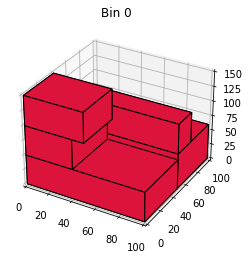

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
%matplotlib inline
def getSolutionBox(i):
    box = boxes[i]
    used_in = [b for b in B if solution.get_value(u[i][b]) == 1]
    if len(used_in) == 0:
        return None
    bin = used_in[0]
    return Box(
        box.id,
        solution.get_value(x[i]),
        solution.get_value(y[i]),
        solution.get_value(z[i]),
        box.w,
        box.d,
        box.h,
        bin)

def cuboid_data(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def getCubeCollection(boxes,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(boxes)
    g = []
    for box in boxes:
        g.append(cuboid_data((box["x"], box["y"], box["z"]), (box["width"], box["depth"], box["height"])))
    return Poly3DCollection(np.concatenate(g), facecolors=np.repeat(colors,6), **kwargs)

def plotBox(box, ax=None,**kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    # Plotting a cube element at position pos
    if ax !=None:
        X, Y, Z = cuboid_data((box["x"], box["y"], box["z"]), (box["width"], box["depth"], box["height"]) )
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, **kwargs)
        surf.patch.set_edgecolor('black')
        ax.plot_wireframe(X, Y, Z, rstride=1, cstride=1, color="black", **kwargs)

colors = ["crimson","limegreen", "navy", "purple"]

if solution and solution.is_valid_solution():
    solutions = [getSolutionBox(i) for i in I]
    milpBoxes = [sol.to_dict() for sol in solutions if sol != None]
    openedBins = [b for b in B if solution.get_value(v[b]) == 1]
    binPerRows = min(len(openedBins), 4)
    plotRows = int(len(openedBins)/binPerRows)
    fig = plt.figure(figsize=plt.figaspect(plotRows/binPerRows))
    idx = 0
    for bin in openedBins:
        idx += 1
        ax = fig.add_subplot(plotRows, binPerRows, idx, projection='3d')
        ax.set_title("Bin " + str(bin))
        ax.set_zlim(0, max([box["z"]+box["height"] for box in milpBoxes if box["bin"] == bin]))
        ax.set_ylim(0, D)
        ax.set_xlim(0, W)
        ax.add_collection3d(getCubeCollection([box for box in milpBoxes if box["bin"] == bin], colors=colors, edgecolor="k"))
else:
    print("Infeasible")

In [198]:
## Check solution
def overlaps(xmin1, xmin2, xmax1, xmax2):
    return xmax1 > xmin2 and xmin1 < xmax2

def overlapArea(boxi, boxj):
    dx = (boxi.x - boxj.x)
    dy = (boxi.y - boxj.y)
    ximax = boxi.w
    yimax = boxi.d
    xkmax = dx + boxj.w
    ykmax = dy + boxj.d
    dx = min(ximax, xkmax) - max(0, dx)
    dy = min(yimax, ykmax) - max(0, dy)
    #value = 0 if dx<0 or dy<0 else dx*dy
    #if value != 0:
    #    print("Overlap {},{},{},{},{},{} = {}".format(i, b1, k, b2, xk, yk, value))
    return 0 if dx<0 or dy<0 else dx*dy

def checkSolution():
    solutions = [getSolutionBox(i) for i in I]
    nonNulls = [box for box in solutions if box != None]
    if len(nonNulls) != len(originalBoxes):
        return False
    for box in nonNulls:
        for other in nonNulls:
            if other != box and other.bin == box.bin:
                overlapX = overlaps(box.x, other.x, box.x + box.w, other.x + other.w)
                overlapY = overlaps(box.y, other.y, box.y + box.d, other.y + other.d)
                overlapZ = overlaps(box.z, other.z, box.z + box.h, other.z + other.h)
                if overlapX and overlapY and overlapZ:
                    print("Box {} overlaps box {}".format(box.id, other.id))
                    return False
    for box in nonNulls:
        supp_area = 0
        if box.z > beta_s:
            for other in nonNulls:
                if other != box and other.bin == box.bin and other.z + other.h <= box.z and box.z - (other.z + other.h) <= beta_s:
                    supp_area += overlapArea(box, other)
            if supp_area < alpha_s*box.w*box.d:
                print("Box {} got area support {}".format(box.id, supp_area/(box.w*box.d)))
                return False
    return True
    

if not checkSolution():
    print("ERROR!")
else:
    print("OK!")

OK!


## Heuristic Solution

In [155]:
import requests
import time

boxes = originalBoxes

class Problem:
    def __init__(self, W, D, H, boxes):
        self.bins = [
            {
                "id": "Bin",
                "width": W,
                "depth": D,
                "height": H,
                "maxLoad": 999.0
            }
        ]
        self.boxes = boxes
        self.configuration = {
            "layer_packing": False,
            "support_area_threshold": 0.7,
            "overflow": 0,
            "tolerance": 0
        }
        self.solution = None
    def toJSON(self):
        return json.dumps(self, default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
        

prob = Problem(W, D, H, [boxes[i].to_packer_box() for i in I])
r = requests.post("http://localhost:4567/jobs", data=prob.toJSON())

jobId = r.json()["job_id"]

sol = None
while(sol == None):
    time.sleep(0.2)
    sol = requests.get("http://localhost:4567/jobs/" + str(jobId))
    if sol.status_code == 500:
        break
    if not sol.status_code == 200:
        sol = None

if sol.json()["status"] == "completed":
    solBins = sol.json()["solution"]["bins"]
    binPerRows = min(len(solBins), 4)
    plotRows = int(len(solBins)/binPerRows)
    fig = plt.figure(figsize=plt.figaspect(plotRows/binPerRows))
    idx = 0
    for bin in solBins:
        idx += 1
        ax = fig.add_subplot(plotRows, binPerRows, idx, projection='3d')
        ax.set_title(bin["id"])
        ax.set_zlim(0, H)
        ax.set_ylim(0, D)
        ax.set_xlim(0, W)
        ax.add_collection3d(getCubeCollection([box for box in bin["boxes"]], colors=colors, edgecolor="k"))

IndexError: list index out of range